In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from MEAData import MEAData
import glob

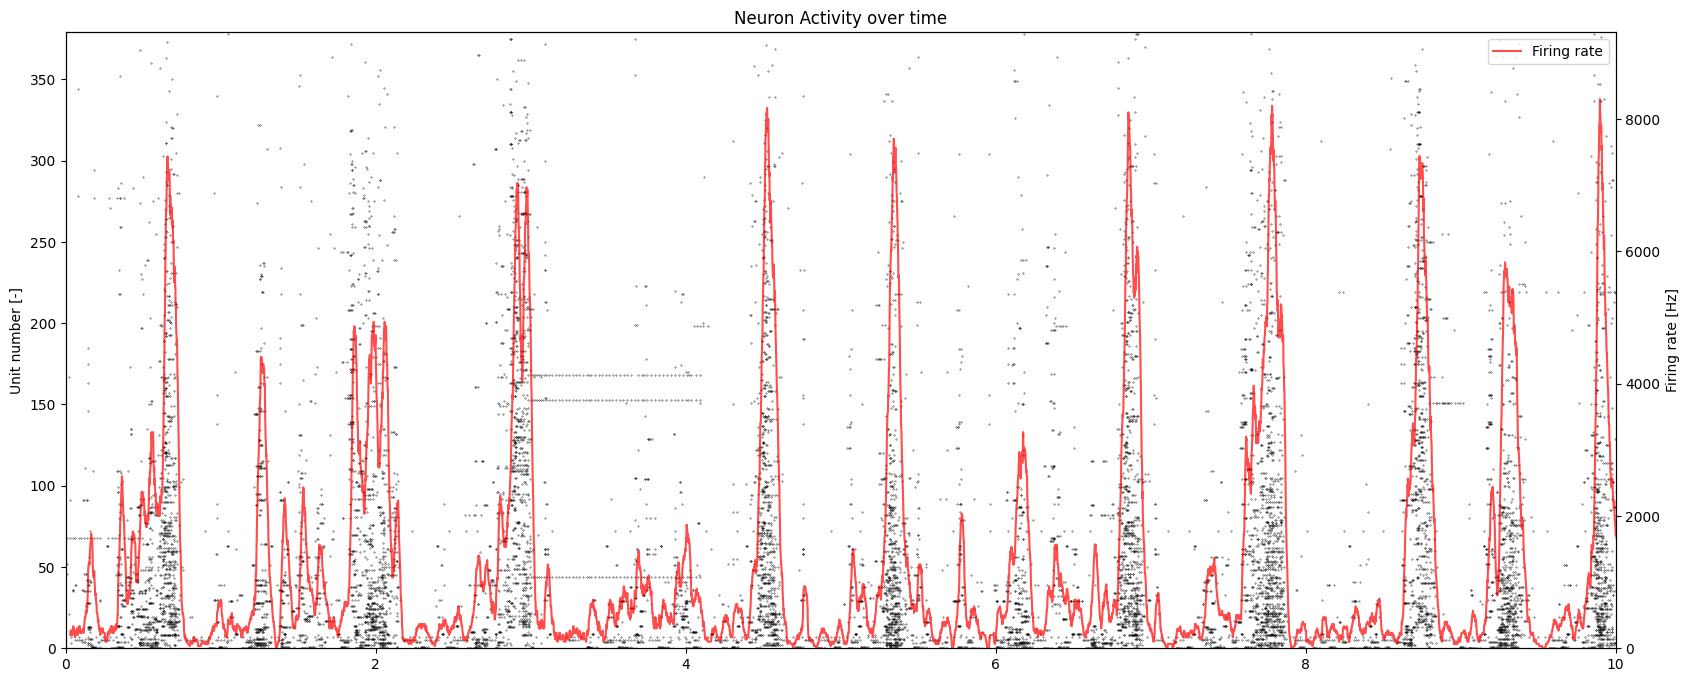

In [4]:
folders = glob.glob('C:\\Users\\bow-lab\\Documents\\Code\\data\\240917_results\\24039_results\\000*')

files = []

pressures = np.array([2.14, 4.44, 6.54, 8.56, 10.18, 11.75, 16.02, 18.03, 20.12,
                      0,    2.17, 4.29, 4.29, 6.33, 9.09, 10.16, 14.09, 16.12, 18.00, 20.0])

for folder in folders:
    files.append(f'{folder}\\sorted.npz')

MEA_data = MEAData(files[0], overview=False)
MEA_data.plot_all_data(time_range=(0, 10))

In [ ]:
def spike_contrast(binary_firings : np.array,
                   sample_rate : float,
                   dt_min : float = None,
                   dt_max : float = None,
                   N_points : int = 100,
                   stride_bin_ratio : int = 2) -> np.array:
    
    N_neurons, N_samples = np.shape(binary_firings)
    
    tot_firings = np.sum(binary_firings, axis=0)

    if dt_min is None:
        dt_min = 0.001
    if dt_max is None:
        dt_max = N_samples / sample_rate / 2

    dts = np.geomspace(dt_min, dt_max, N_points)

    contrast = []
    activeST = []

    for dt in tqdm(dts):
        half_bin_size = int(dt * sample_rate / stride_bin_ratio)
        bin_edges = np.arange(0, N_samples, half_bin_size)
        bin_edges = np.append(bin_edges, [N_samples]) #add the last bin edge of the last truncated bin

        theta_k = np.zeros(len(bin_edges) - 1)
        n_k = np.zeros(len(bin_edges) - 1)

        for k in range(len(bin_edges)-stride_bin_ratio):
            theta_k[k] = np.sum(tot_firings[bin_edges[k]:bin_edges[k+stride_bin_ratio]])
            sum = np.sum(binary_firings[:,bin_edges[k]:bin_edges[k+stride_bin_ratio]], axis=1)
            n_k[k] = len(np.argwhere(sum > 0))


        contrast.append(np.sum(np.abs(np.diff(theta_k))) / (2 * np.sum(theta_k)))
        activeST.append( (np.sum(n_k*theta_k) / np.sum(theta_k) - 1) / (N_neurons-1))

    contrast = np.array(contrast)
    activeST = np.array(activeST)

    spike_contrast = contrast * activeST

    return spike_contrast, contrast, activeST, dts

In [ ]:
spike_contrast, activeST, contrast, dts = spike_contrast(MEA_data.spikes_binary, MEA_data.sample_rate, dt_min=.01, dt_max=100)

100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


(0.37649358067924693, 0.13319896440559575)

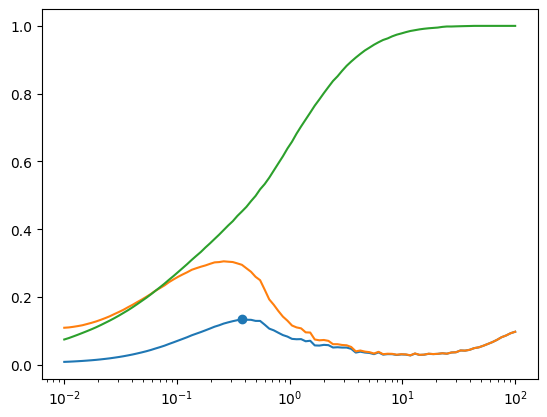

In [ ]:
plt.plot(dts, spike_contrast)
plt.scatter(dts[np.argmax(spike_contrast)], np.max(spike_contrast))
plt.plot(dts, contrast)
plt.plot(dts, activeST)
plt.xscale('log')

dts[np.argmax(spike_contrast)], np.max(spike_contrast)

In [ ]:
all_data = []
C_list = []
activeST_list = []
contrast_list = []

for file, pressure in zip(files[9:], pressures[9:]):
    print(f'____{file.split('\\')[-2]}____')
    data = MEAData(file, pressure=pressure, overview=False)
    spike_contrast, activeST, contrast, dts = spike_contrast(data.spikes_binary, data.sample_rate, dt_min=.01, dt_max=1)

    all_data.append(data)
    C_list.append(spike_contrast)
    activeST_list.append(activeST)
    contrast_list.append(contrast)

____000287____


100%|██████████| 100/100 [04:26<00:00,  2.66s/it]


____000288____


100%|██████████| 100/100 [04:18<00:00,  2.59s/it]


____000290____


100%|██████████| 100/100 [04:23<00:00,  2.64s/it]


____000292____


100%|██████████| 100/100 [04:32<00:00,  2.72s/it]


____000294____


100%|██████████| 100/100 [04:16<00:00,  2.57s/it]


____000295____


100%|██████████| 100/100 [04:44<00:00,  2.85s/it]


____000296____


100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


____000298____


100%|██████████| 100/100 [04:59<00:00,  3.00s/it]


____000299____


100%|██████████| 100/100 [05:03<00:00,  3.03s/it]


____000300____


100%|██████████| 100/100 [05:25<00:00,  3.25s/it]


____000301____


MemoryError: Unable to allocate 2.76 GiB for an array with shape (494, 6000996) and data type bool

In [87]:
def make_SC_figure(spike_contrasts : np.array,
                   contrasts,
                   activeSTs,
                   dts : np.array) -> None:
    sc_max = []
    dts_max = []
    i_max = []
    for sc in spike_contrasts:
        sc_max.append(np.max(sc))
        i_max.append(np.argmax(sc))
        dts_max.append(dts[np.argmax(sc)])


    ymins = np.array([])
    ymaxs = np.array([])

    for sc in spike_contrasts:
        ymins = np.append(ymins, np.min(sc))
        ymaxs = np.append(ymaxs, 1.1*np.max(sc))

    _, axs = plt.subplots(len(spike_contrasts), 1, sharex=True, height_ratios=(ymaxs-ymins), figsize=(6, 12))
    plt.subplots_adjust(hspace=0)
    axs[0].set_title('Spike contrast')

    for i, (ax, sc, c, a) in enumerate(zip(axs, spike_contrasts, contrasts, activeSTs)):

        ax.plot(dts, sc, c='k')
        ax.plot(dts, c, c='g')
        ax.twinx().plot(dts, a, c='b')
        ax.scatter(dts_max[i], sc_max[i], c='r', marker='s')
        ax.set_xscale('log')
        ax.set_yticks([ymins[i], sc_max[i]], [round(ymins[i], 2), round(sc_max[i], 2)], fontsize=8)
        #ax.set_ylim(ymins[i], ymaxs[i])
        ax.hlines(sc_max[i], np.min(dts), dts_max[i], color='k', linestyle=':')

        if i == len(spike_contrasts[:9]) // 2:
            ax.set_ylabel('Spike contrast [-]', fontsize=15)

        if i > 0:
            if dts_max[i] == dts_max[i-1]:
                ax.plot([dts_max[i], dts_max[i]], [ymaxs[i], sc_max[i]], c='r', linestyle='--')
            else:
                slope = ( sc_max[i-1]-ymins[i-1]+ymaxs[i]-sc_max[i] ) / (dts_max[i]-dts_max[i-1])
                x = (sc_max[i] - ymaxs[i]) / slope + dts_max[i]
                ax.plot([x, dts_max[i]], [ymaxs[i], sc_max[i]], c='r', linestyle='--')
        if i < len(spike_contrasts)-1:
            if dts_max[i] == dts_max[i+1]:
                ax.plot([dts_max[i], dts_max[i]], [sc_max[i], ymins[i]], c='r', linestyle='--')
            else:
                slope = ( sc_max[i]-ymins[i]+ymaxs[i+1]-sc_max[i+1] ) / (dts_max[i+1]-dts_max[i])
                x = (sc_max[i] - ymins[i]) / slope + dts_max[i]
                ax.plot([dts_max[i], x], [sc_max[i], ymins[i]], c='r', linestyle='--')

    axs[-1].set_xlim(np.min(dts), np.max(dts))
    axs[-1].set_xlabel(r'$\Delta t$ [s]', fontsize=15)
    plt.show()

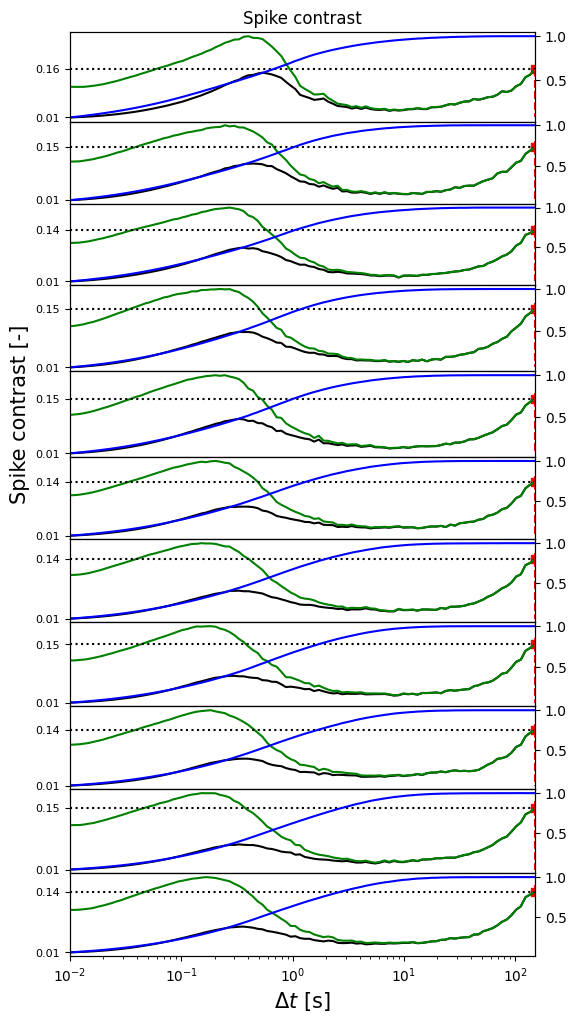

In [88]:
make_SC_figure(C_list, contrast_list, activeST_list, dts)

In [1]:
sc_max_trial1 = []
dts_max_trial1 = []
for sc in C_list:
        sc_max_trial1.append(np.max(sc[:50]))
        dts_max_trial1.append(dts[np.argmax(sc[:50])])

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axs[0].set_title(r'max(SC($\Delta t$)), $\Delta t_{max}$ as function of pressure, trial 1')
axs[0].plot(pressures, sc_max_trial1, c='k', marker='s')
axs[0].grid(True)
axs[0].set_ylabel(r'max(SC($\Delta t$)) [-]')

axs[1].plot(pressures, dts_max_trial1, c='k', marker='s')
axs[1].grid(True)
axs[1].set_xlabel('Xenon pressure [psi]')
axs[1].set_ylabel(r'$\Delta t_{max}$ [s]')
plt.show()

NameError: name 'C_list' is not defined

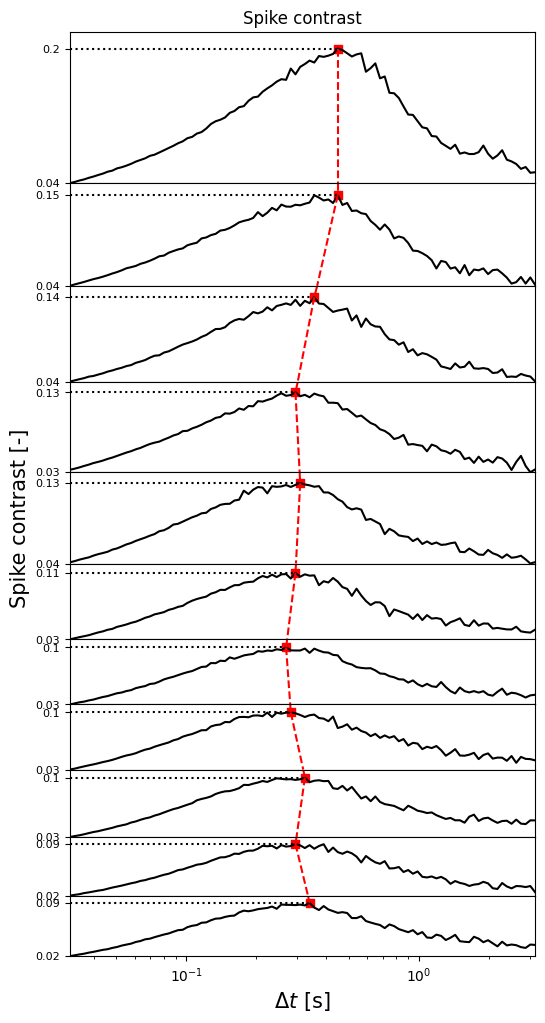

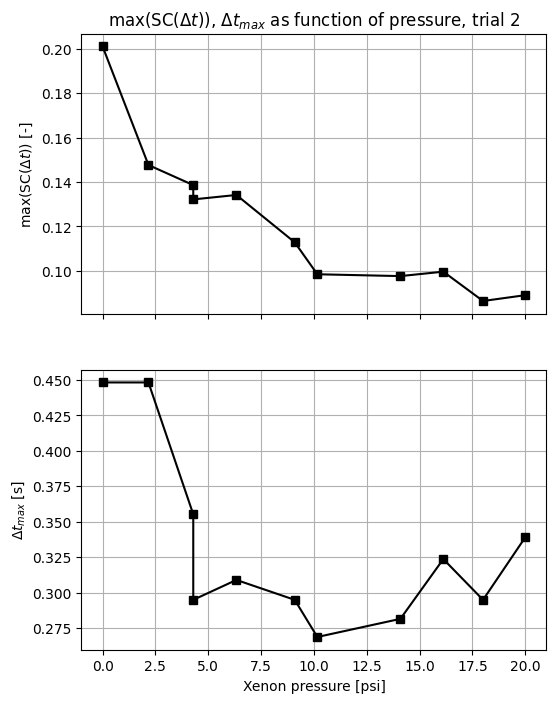

In [123]:
make_SC_figure(spike_contrasts_trial2)

sc_max_trial2 = []
dts_max_trial2 = []
for sc in spike_contrasts_trial2:
        sc_max_trial2.append(np.max(sc))
        dts_max_trial2.append(dts[np.argmax(sc)])

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axs[0].set_title(r'max(SC($\Delta t$)), $\Delta t_{max}$ as function of pressure, trial 2')
axs[0].plot(pressures_trial2, sc_max_trial2, c='k', marker='s')
axs[0].grid(True)
axs[0].set_ylabel(r'max(SC($\Delta t$)) [-]')

axs[1].plot(pressures_trial2, dts_max_trial2, c='k', marker='s')
axs[1].grid(True)
axs[1].set_xlabel('Xenon pressure [psi]')
axs[1].set_ylabel(r'$\Delta t_{max}$ [s]')
plt.show()

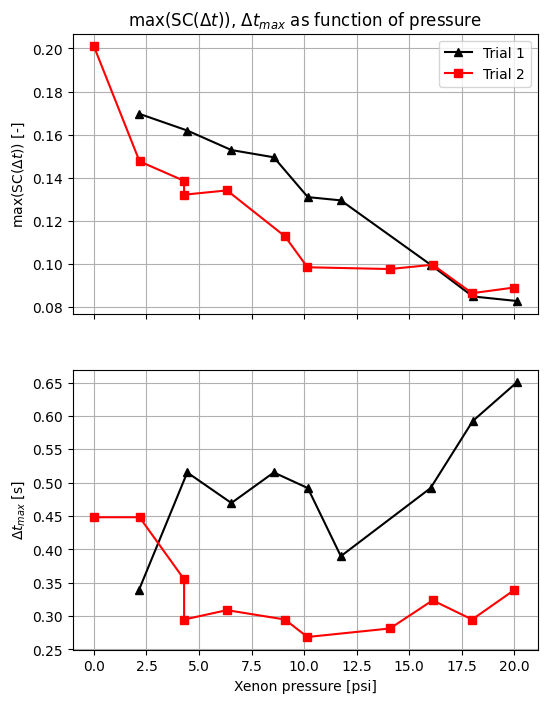

In [124]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axs[0].set_title(r'max(SC($\Delta t$)), $\Delta t_{max}$ as function of pressure')
axs[0].plot(pressures_trial1, sc_max_trial1, c='k', marker='^', label='Trial 1')
axs[0].plot(pressures_trial2, sc_max_trial2, c='r', marker='s', label='Trial 2')
axs[0].grid(True)
axs[0].set_ylabel(r'max(SC($\Delta t$)) [-]')
axs[0].legend()

axs[1].plot(pressures_trial1, dts_max_trial1, c='k', marker='^')
axs[1].plot(pressures_trial2, dts_max_trial2, c='r', marker='s')
axs[1].grid(True)
axs[1].set_xlabel('Xenon pressure [psi]')
axs[1].set_ylabel(r'$\Delta t_{max}$ [s]')

plt.show()